# EEG Data Processing using NATVIEW_EEGFMRI data

## Background

This project provides a detailed analysis of NATVIEW_EEGFMRI data using **MNE Python**. The **NATVIEW_EEGFMRI** dataset is a publicly available resource that comprises simultaneous EEG-fMRI recordings from healthy participants during naturalistic movie-watching tasks across two days, including a flickering checkerboard task, naturalistic videos (e.g., "The Present," "Despicable Me" clips, and monkey videos), and resting state scans. EEG data was collected using a 128-channel BrainAmp MR-compatible system, with events logged as annotations to mark stimulus onsets and synchronization pulses, providing a comprehensive dataset for studying brain dynamics in naturalistic settings.

The data was collected at the Nathan S. Kline Institute for Psychiatric Research (NKI) in Orangeburg, NY. The participants enrolled in this study have **no history of psychiatric or neurologic abnormalities**. As a part of data processing, the gradient and ballistocardiogram artifacts have been removed. Therefore, we will focus on ocular artifacts, which are prominent in this study.

In this project, we are using the data of the first participant in both the stimulus and rest stages. The EEG data is downloaded in EDF format. 

### Data Sources
The data used in this project was downloaded from Kaggle and processed by Chris Gorgolewski. The link to the data: https://www.kaggle.com/datasets/chrisfilo/natview-eeg-fmri/data

The study is available online at Nature: https://www.nature.com/articles/s41597-023-02458-8

The Matlab raw data processing is available at GitHub: https://github.com/NathanKlineInstitute/NATVIEW_EEGFMRI


### Data Exploration

In [1]:
#import packages
import os
import numpy as np
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
import matplotlib
matplotlib.use('inline')


##### import check data (Stimulus data)

In [2]:
check = mne.io.read_raw_edf('C:/Users/amany/Downloads/export/sub-01_ses-01_task-checker_run-01_eeg.edf', preload = True)

Extracting EDF parameters from C:\Users\amany\Downloads\export\sub-01_ses-01_task-checker_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 60499  =      0.000 ...   241.996 secs...


##### import rest data

In [3]:
rest = mne.io.read_raw_edf('C:/Users/amany/Downloads/export/sub-01_ses-01_task-rest_run-01_eeg.edf', preload = True)

Extracting EDF parameters from C:\Users\amany\Downloads\export\sub-01_ses-01_task-rest_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 155749  =      0.000 ...   622.996 secs...


##### Data Description

In [4]:
check.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>

In [5]:
rest.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>

- The info MNE object provides a detailed description of the EEG data. The output shows that the Nyquist frequency (the highest frequency that can be accurately represented) is half the sampling rate: 500 Hz / 2 = 250 Hz. 

- There are 64 EEG channels, including EOG and ECG channels. 

- The EEG montage is unidentified. In the study, reference electrodes were used using an average reference, excluding the ECG channel, EOG channels, and electrodes excluded during the EEG quality control process.

- A low-pass filter at 125 Hz ensures that frequencies above 125 Hz are attenuated, preventing aliasing for a 500 Hz sampling rate. A bandpass filter using a Hamming windowed sinc FIR filter between 0.5 Hz and 70 Hz was applied during the preprocessing stage. However, this information is not reflected in the description.



**Next Steps**

1- Setting up EOG and ECG channels. This step is important to ensure that ECG and EOG channels will be identified in the montage stage.

2- Setting up EEG montage.

3- Apply bandpass filter.

4- Artifact Inspection

#### Set EOG and ECG Channel Types

##### Check data

In [6]:
check = check.set_channel_types({'EOGL': 'eog'},  on_unit_change='warn', verbose=None)
check = check.set_channel_types({'EOGU': 'eog'},  on_unit_change='warn', verbose=None)
check = check.set_channel_types({'ECG': 'ecg'},  on_unit_change='warn', verbose=None)
check.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 61 EEG, 1 ECG, 2 EOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>

##### Rest data

In [7]:
rest = rest.set_channel_types({'EOGL': 'eog'},  on_unit_change='warn', verbose=None)
rest = rest.set_channel_types({'EOGU': 'eog'},  on_unit_change='warn', verbose=None)
rest = rest.set_channel_types({'ECG': 'ecg'},  on_unit_change='warn', verbose=None)
rest.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 61 EEG, 1 ECG, 2 EOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>


The channels section is updated by identifying ECG and EOG channels


#### Set montage for eeg data

In [8]:
# Set a standard 10-10 montage with 128 channels
# MNE provides a 'standard_1005' montage that includes 10-10 system positions
montage = mne.channels.make_standard_montage('standard_1020')
print(montage)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 94 channels>


##### Check data

In [9]:
# Ensure channel names match the montage (you may need to rename channels if they differ)
# For BrainAmp systems, channel names are typically in the 10-10 system (e.g., Fp1, Fp2, Cz)
# If your data includes extra channels (e.g., ECG, EOG), they won't be in the montage but can remain
check.set_montage(montage, on_missing='ignore')
check_eeg_data = check.copy().pick_types(eeg = True, eog = True, ecg = True)
check_eeg_data = check_eeg_data.set_montage('standard_1020')
check_eeg_data.info

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 61 EEG, 1 ECG, 2 EOG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>

##### Rest Data

In [10]:
rest.set_montage(montage, on_missing='ignore')
rest_eeg_data = rest.copy().pick_types(eeg = True, eog = True, ecg = True)
rest_eeg_data = rest_eeg_data.set_montage('standard_1020')
rest_eeg_data.info

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 61 EEG, 1 ECG, 2 EOG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>

The Head & sensor digitization is now updated with 64 points

### Check Data events

The data has no recorded events. Therefore, we will use data annotations to explore and create events

##### 1- Check Data

In [11]:
# Step 1: Convert annotations to events
events, event_id = mne.events_from_annotations(check_eeg_data)
print("Event ID dictionary:", event_id)

Used Annotations descriptions: [np.str_('New Segment'), np.str_('R'), np.str_('R128'), np.str_('S  1'), np.str_('S 10'), np.str_('S 11'), np.str_('S 12'), np.str_('S 25'), np.str_('S 26'), np.str_('S 27'), np.str_('S 99'), np.str_('Sync On'), np.str_('TEND'), np.str_('TPEAK'), np.str_('TSTART'), np.str_('Time 0'), np.str_('Userdefined Artifact')]
Event ID dictionary: {np.str_('New Segment'): 1, np.str_('R'): 2, np.str_('R128'): 3, np.str_('S  1'): 4, np.str_('S 10'): 5, np.str_('S 11'): 6, np.str_('S 12'): 7, np.str_('S 25'): 8, np.str_('S 26'): 9, np.str_('S 27'): 10, np.str_('S 99'): 11, np.str_('Sync On'): 12, np.str_('TEND'): 13, np.str_('TPEAK'): 14, np.str_('TSTART'): 15, np.str_('Time 0'): 16, np.str_('Userdefined Artifact'): 17}


**Based on the annotations:**

**1- "S  1", "S 10", "S 11", "S 12", "S 25", "S 26", "S 27", "S 99" likely correspond to the onsets of different stimuli or conditions in the experiment**

  - "S  1" might mark the start of a flickering checkerboard block.

  - "S 10", "S 11", "S 12" might mark the start of different video clips (e.g., "The Present", "Despicable Me" clip 1, "Despicable Me" clip 2).

  - "S 25", "S 26", "S 27" might mark the start of the monkey videos (Monkey 1, Monkey 2, Monkey 5).

  - "S 99" might mark the start of a resting state period.

**2- "Sync On":  these markers (e.g., at 0, 50, 100, 150, 200 seconds in the check EEG data) are likely synchronization pulses sent at regular intervals to align the EEG and stimulus presentation systems. They may not directly correspond to stimulus onsets but are useful for timing alignment**

**3- "R" and "R128" were used to mark heartbeat events (R-peaks) for identifying cardiac artifacts**



In [12]:
# Step 2: Identify stimulus events (e.g., "S  1", "S 10", etc.)
# List of stimulus event labels based on your annotations
stimulus_labels = ['S  1', 'S 10', 'S 11', 'S 12', 'S 25', 'S 26', 'S 27', 'S 99']

# Extract events for each stimulus type
stimulus_events = {}
for label in stimulus_labels:
    if label in event_id:
        stim_id = event_id[label]  # Get the event ID for the stimulus
        stim_events = events[events[:, 2] == stim_id]  # Filter for this stimulus type
        stimulus_events[label] = stim_events
        # Convert sample numbers to time (in seconds)
        sfreq = check_eeg_data.info['sfreq']  # Sampling frequency (Hz)
        stim_times = stim_events[:, 0] / sfreq
        print(f"{label} event times (seconds):", stim_times)
    else:
        print(f"No events found for {label}")

# Step 3: Combine all stimulus events (optional)
# Concatenate all stimulus events into a single array
all_stimulus_events = np.concatenate([stimulus_events[label] for label in stimulus_events], axis=0)
# Sort by sample number to maintain chronological order
all_stimulus_events = all_stimulus_events[all_stimulus_events[:, 0].argsort()]
print(all_stimulus_events)


S  1 event times (seconds): [33.42]
S 10 event times (seconds): [ 33.42   73.42  113.416 153.416 193.412]
S 11 event times (seconds): [ 33.424  34.42   35.42   36.42   37.42   38.42   39.42   40.42   41.42
  42.42   43.42   44.42   45.42   46.42   47.42   48.42   49.42   50.42
  51.42   52.42   73.42   74.42   75.42   76.42   77.42   78.42   79.42
  80.42   81.42   82.42   83.42   84.42   85.42   86.42   87.42   88.416
  89.416  90.416  91.416  92.416 113.42  114.416 115.416 116.416 117.416
 118.416 119.416 120.416 121.416 122.416 123.416 124.416 125.416 126.416
 127.416 128.416 129.416 130.416 131.416 132.416 153.416 154.416 155.412
 156.412 157.412 158.412 159.412 160.412 161.412 162.412 163.412 164.412
 165.412 166.412 167.412 168.412 169.412 170.412 171.412 172.412 193.412
 194.412 195.412 196.412 197.412 198.412 199.412 200.412 201.412 202.412
 203.412 204.412 205.412 206.412 207.412 208.412 209.412 210.412 211.412
 212.412]
S 12 event times (seconds): [ 33.428  35.424  37.424  39

##### 2- Rest Data

In [13]:
# Step 1: Convert annotations to events
events, event_id = mne.events_from_annotations(rest_eeg_data)
print("Event ID dictionary:", event_id)

Used Annotations descriptions: [np.str_('New Segment'), np.str_('R'), np.str_('R128'), np.str_('S  1'), np.str_('S  5'), np.str_('S 99'), np.str_('Sync On'), np.str_('TEND'), np.str_('TPEAK'), np.str_('TSTART'), np.str_('Time 0'), np.str_('Userdefined Artifact')]
Event ID dictionary: {np.str_('New Segment'): 1, np.str_('R'): 2, np.str_('R128'): 3, np.str_('S  1'): 4, np.str_('S  5'): 5, np.str_('S 99'): 6, np.str_('Sync On'): 7, np.str_('TEND'): 8, np.str_('TPEAK'): 9, np.str_('TSTART'): 10, np.str_('Time 0'): 11, np.str_('Userdefined Artifact'): 12}


**Based on the annotations:**

**The stimulus channels in the rest data are different ('S  1', 'S  5', 'S 99')**

"S  5" most likely marks the onset of the resting state scan in the rest EEG data, which is a 600-second segment where participants fixated on a crosshair. 


In [14]:
# Step 2: Identify stimulus events 
# List of stimulus event labels based on your annotations
stimulus_labels = ['S  1', 'S  5', 'S 99']

# Extract events for each stimulus type
stimulus_events = {}
for label in stimulus_labels:
    if label in event_id:
        stim_id = event_id[label]  # Get the event ID for the stimulus
        stim_events = events[events[:, 2] == stim_id]  # Filter for this stimulus type
        stimulus_events[label] = stim_events
        # Convert sample numbers to time (in seconds)
        sfreq = rest_eeg_data.info['sfreq']  # Sampling frequency (Hz)
        stim_times = stim_events[:, 0] / sfreq
        print(f"{label} event times (seconds):", stim_times)
    else:
        print(f"No events found for {label}")

# Step 3: Combine all stimulus events (optional)
# Concatenate all stimulus events into a single array
all_stimulus_events = np.concatenate([stimulus_events[label] for label in stimulus_events], axis=0)
# Sort by sample number to maintain chronological order
all_stimulus_events = all_stimulus_events[all_stimulus_events[:, 0].argsort()]
print(all_stimulus_events)

S  1 event times (seconds): [7.932]
S  5 event times (seconds): [  7.936   8.932   9.932  10.932  11.932  12.932  13.932  14.932  15.932
  16.932  17.932  18.932  19.932  20.932  21.932  22.932  23.932  24.932
  25.932  26.932  27.932  28.932  29.932  30.932  31.932  32.932  33.932
  34.932  35.932  36.932  37.932  38.932  39.932  40.932  41.932  42.932
  43.932  44.932  45.932  46.932  47.928  48.928  49.928  50.928  51.928
  52.928  53.928  54.928  55.928  56.928  57.928  58.928  59.928  60.928
  61.928  62.928  63.928  64.928  65.928  66.928  67.928  68.928  69.928
  70.928  71.928  72.928  73.928  74.928  75.928  76.928  77.928  78.928
  79.928  80.928  81.928  82.928  83.928  84.928  85.928  86.928  87.928
  88.928  89.928  90.928  91.928  92.928  93.928  94.928  95.928  96.928
  97.928  98.928  99.928 100.928 101.928 102.928 103.928 104.928 105.928
 106.928 107.928 108.928 109.928 110.928 111.928 112.924 113.924 114.924
 115.924 116.924 117.924 118.924 119.924 120.924 121.924 122

### Data Plotting and Interpretation

##### Check data

Using matplotlib as 2D backend.


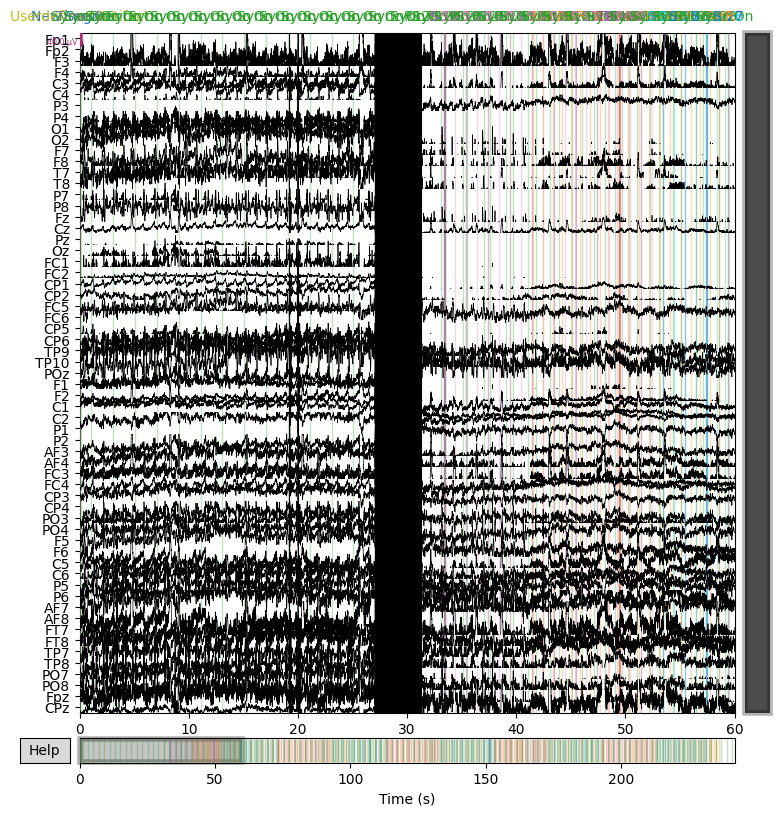

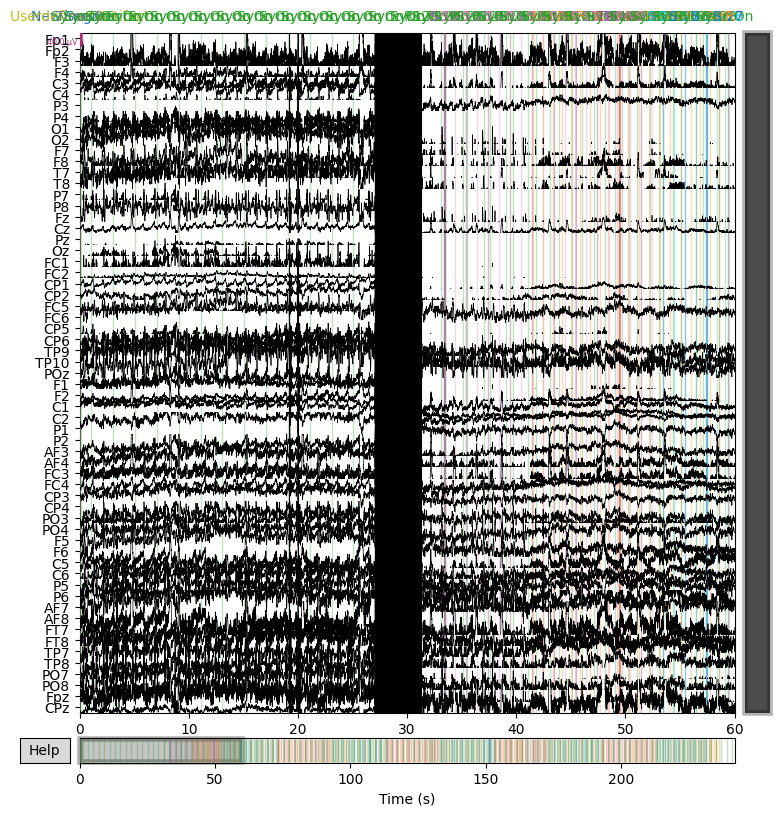

In [15]:
#pick eeg data 
eeg_channels = mne.pick_types(check_eeg_data.info, eeg=True)

#plot eeg channels for 20 seconds and disable channel-wise DC shift correction
check_eeg_data.plot(duration=60, order=eeg_channels, n_channels=len(eeg_channels), remove_dc=False)

**General Signal Characteristics:**

 - The check EEG data (200 seconds) with "Sync On" markers every 50 seconds (0, 50, 100, 150, 200 seconds).

 - A 60-second window (e.g., 0–60 seconds) would include at least one "Sync On" event (at 50 seconds), which might be visible as a vertical marker in the plot.

 - The signal would show high-frequency fluctuations.

**Artifacts:**
 - Ocular Artifacts: As seen in the visualization, eye blinks occur ~100 ms after "Sync On" events, so you might observe large deflections in frontal channels (e.g., Fp1, Fp2) around the 50-second mark.

 - Muscle Artifacts: no obvious artifacts at temporal channels (e.g., T7, T8).

 - Cardiac Artifacts: The "R" and "R128" annotations (heartbeats) suggest potential ballistocardiogram artifacts (common in EEG-fMRI), but it was removed in data preprocessing.

**Synchronization Segment:**
 - The check EEG data likely precedes the main tasks (e.g., checkerboard, "The Present" video), serving to align the EEG and fMRI systems.

 - The "Sync On" events might be associated with a stimulus (e.g., a light or sound) that triggers eye blinks, as seen in your ocular artifact visualizations.

 - The signal might not reflect typical EEG rhythms (e.g., alpha, beta) if the participant was not engaged in a specific task, but artifacts (e.g., eye blinks) would still be present.

**Channel Quality:**
 - Frontal channels (Fp1, Fp2) show ocular artifacts.

 - Other channels might be relatively cleaner but could still be affected by noise if preprocessing (e.g., bandpass filtering, re-referencing) hasn’t been fully applied.



##### Rest data

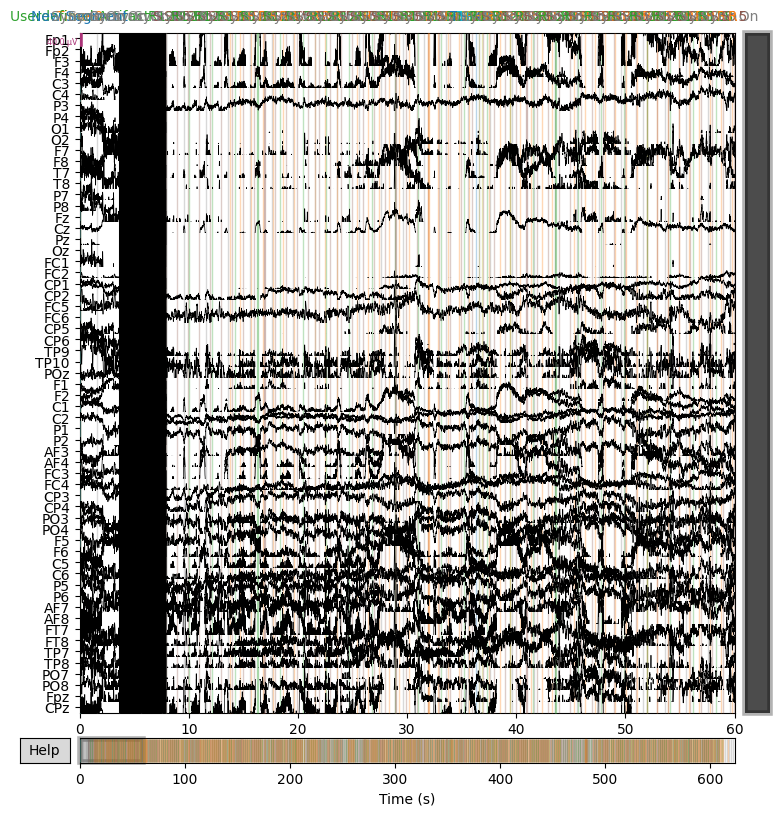

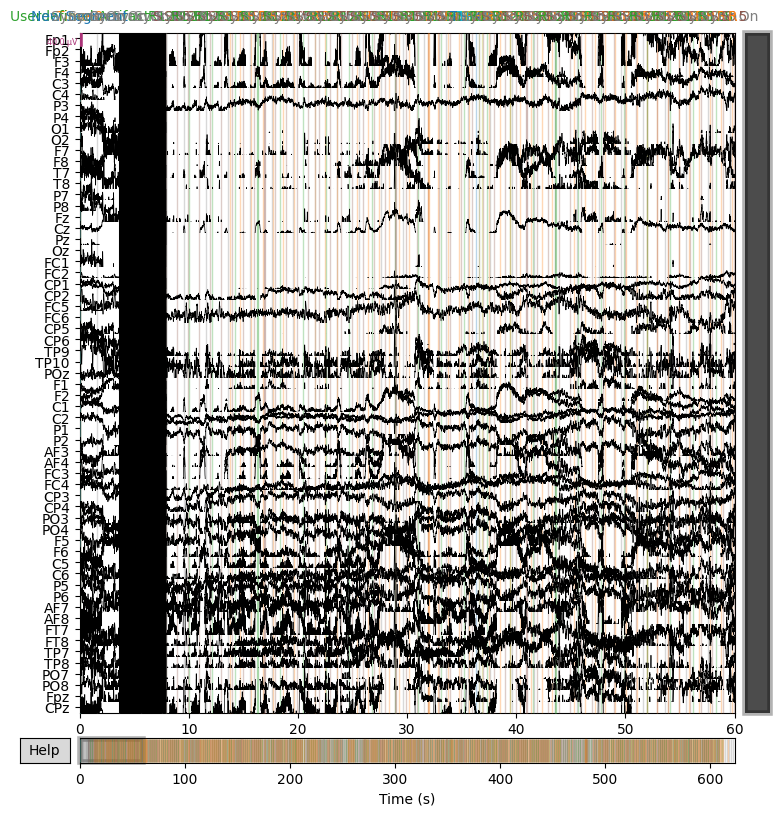

In [16]:
#pick eeg data 
eeg_channels = mne.pick_types(rest_eeg_data.info, eeg=True)

#plot eeg channels for 20 seconds and disable channel-wise DC shift correction
rest_eeg_data.plot(duration=60, order=eeg_channels, n_channels=len(eeg_channels), remove_dc=False)

**General Signal Characteristics:**

 - The EEG traces exhibit high-frequency fluctuations typical of raw EEG data, with amplitudes varying across channels.

 - Channels like Fp1, Fp2 (frontal), and others (e.g., F3, F4, Cz) show dense, overlapping signals, indicating a mix of brain activity and artifacts.


**Artifacts:**

 - Ocular Artifacts: Channels like Fp1 and Fp2 (frontal electrodes) show periodic large-amplitude deflections, likely eye blinks.

 - Muscle Artifacts: Channels like T7, T8, FT7, FT8 (temporal electrodes) show high-frequency, jagged activity, suggesting muscle artifacts (e.g., jaw clenching, head movement), which are common in temporal regions.

 - No Visible "Sync On" Events: The plot labels "UserDefinedEvent/SYNC ON," but no vertical event markers are visible in this 60-second window. Since "Sync On" events occur every 2 seconds (0, 2, 4, ..., 598 seconds), there should be ~30 events in 60 seconds. Their absence might be due to:
The plot window (e.g., 0–60 seconds) not aligning with visible events.


**Resting State Characteristics:**

 - The rest EEG data is expected to show typical resting state activity, such as alpha waves (8–13 Hz) in posterior channels (e.g., O1, O2, Oz) if the participant’s eyes were closed, or low-amplitude, desynchronized activity if eyes were open (fixating on a crosshair).

 - However, the raw data appears noisy, with artifacts dominating the signal. Posterior channels (e.g., O1, O2) don’t show clear alpha activity, possibly because:
  - The participant’s eyes were open (suppressing alpha).

  - Artifacts (e.g., eye blinks, muscle activity) obscure the underlying brain activity.

**Channel Quality:**
 - Frontal channels (Fp1, Fp2) show ocular artifacts.

 - Some channels (e.g., TP9, TP10, mastoid electrodes) show relatively cleaner signals, possibly because they are less affected by ocular and muscle artifacts.


### Power line noise plots

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\amany\opencv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


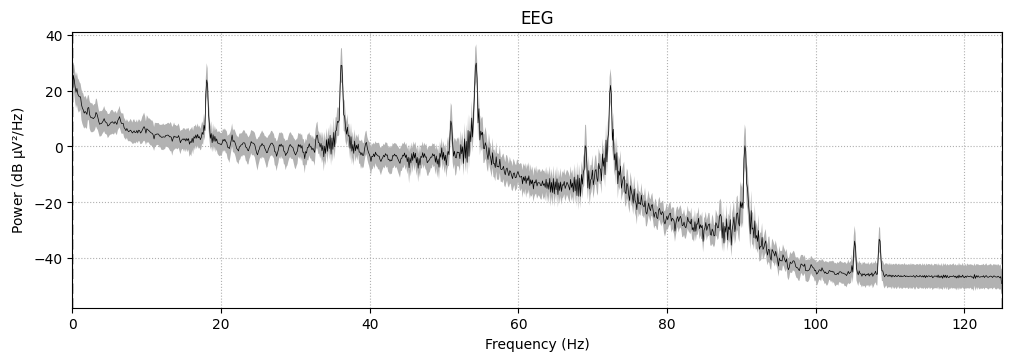

In [17]:
fig = check_eeg_data.compute_psd(tmax=np.inf, fmax=125).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (30, 60, 90, 125):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(
            x=freqs[idx],
            y=psds[idx] + 18,
            dx=0,
            dy=-12,
            color="red",
            width=0.1,
            head_width=3,
            length_includes_head=True,
        )

**Frequencies:**

 - Low Frequencies (0–10 Hz): High power in the delta (0.5–4 Hz) and theta (4–8 Hz) bands, consistent with a synchronization segment where the participant might not be engaged in a specific task.

 - Alpha Band (8–13 Hz): A small peak around 10 Hz might indicate alpha activity, though it’s not prominent, possibly because the participant’s eyes were open during the synchronization segment (alpha is typically stronger with eyes closed).

 - Beta and Gamma Bands (13–70 Hz): Power decreases steadily, with minor fluctuations. The 60 Hz peak interrupts this trend, but no other significant peaks are visible in the beta (13–30 Hz) or gamma (30–70 Hz) bands.

 - Above 70 Hz: Power drops significantly but doesn’t reach zero, as the hardware filter (125 Hz) allows frequencies up to 125 Hz. The 120 Hz peak is the only notable feature in this range.

**Preprocessing Alignment:**
The article specifies a 0.5 Hz to 70 Hz bandpass filter, but the plot shows power up to 125 Hz, suggesting that this preprocessing step hasn’t been fully applied. The presence of power above 70 Hz aligns with the hardware filter (125 Hz) rather than the preprocessing filter (70 Hz).

The 60 Hz and 120 Hz peaks indicate that power line noise correction (e.g., notch filtering) hasn’t been applied.



Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\amany\opencv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


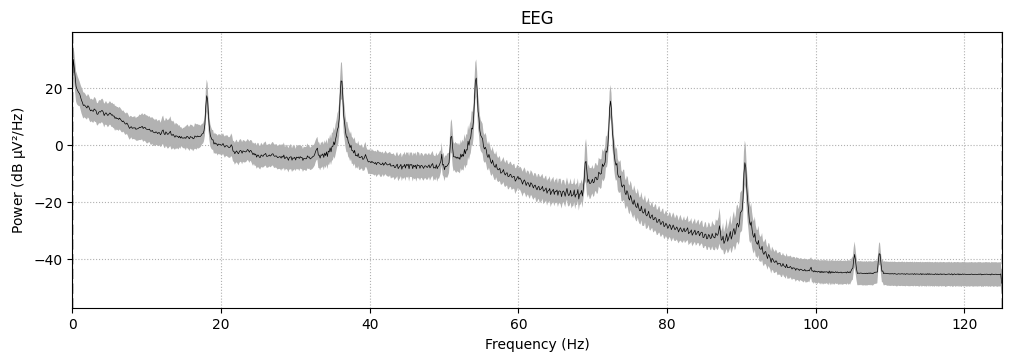

In [18]:
fig = rest_eeg_data.compute_psd(tmax=np.inf, fmax=125).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (30, 60, 90, 125):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(
            x=freqs[idx],
            y=psds[idx] + 18,
            dx=0,
            dy=-12,
            color="red",
            width=0.1,
            head_width=3,
            length_includes_head=True,
        )

**Frequencies:**

 - Low Frequencies (0–10 Hz): High power in the delta and theta bands, consistent with a resting state scan where participants fixated on a crosshair. The power in this range is slightly higher than in the check EEG data, possibly due to the longer duration (~600 seconds) and the resting state condition.

 - Alpha Band (8–13 Hz): A small peak around 10 Hz might indicate alpha activity, though it’s not prominent. In a resting state with eyes open (fixating on a crosshair), alpha activity is typically suppressed, which aligns with the lack of a strong alpha peak.

 - Beta and Gamma Bands (13–70 Hz): Power decreases steadily, with the 60 Hz peak being the most notable feature. No significant peaks in the beta or gamma bands, suggesting minimal high-frequency brain activity or artifacts (e.g., muscle activity) after averaging across channels.

 - Above 70 Hz: Similar to the check EEG data, power drops but remains non-zero up to 125 Hz due to the hardware filter. The 120 Hz peak is visible, but no other significant features are present.

**Preprocessing Alignment:**

Like the check EEG data, the rest EEG data shows power up to 125 Hz, indicating that the 0.5 Hz to 70 Hz bandpass filter hasn’t been fully applied (or isn’t reflected in the plot). The 60 Hz and 120 Hz peaks suggest that power line noise correction is needed.



##### Apply the Bandpass Filter:

##### Check data

In [20]:
check_eeg_data.filter(l_freq=0.5, h_freq=70, method='fir', fir_window='hamming')
check_eeg_data.info

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 61 EEG, 1 ECG, 2 EOG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 0.5 Hz
 lowpass: 70.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>

The filters information has been updated

##### Investigate Alpha Activity in occipital regions

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\amany\opencv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


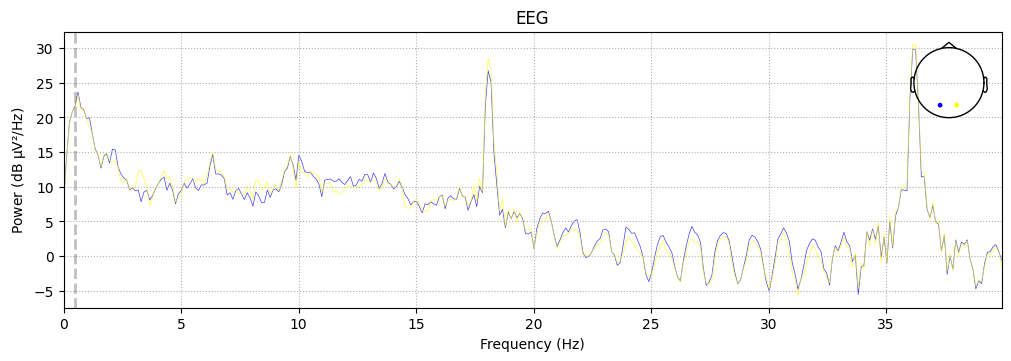

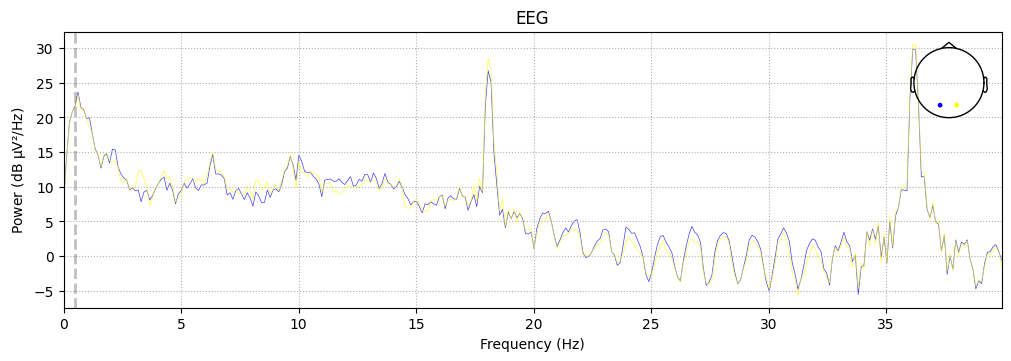

In [21]:
check_eeg_data.compute_psd(tmax=np.inf, fmax=40).plot(picks=['O1', 'O2'])

There is a clearly visible and symmetric alpha peak (~10 Hz) in both O1 and O2, indicating normal, strong alpha activity in the occipital region, typically seen in relaxed, awake individuals with eyes closed. That suggests that the subject was likely in an eyes-closed resting state.

##### Rest data

In [28]:
rest_eeg_data.filter(l_freq=0.5, h_freq=70, method='fir', fir_window='hamming')
rest_eeg_data.info

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 61 EEG, 1 ECG, 2 EOG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 0.5 Hz
 lowpass: 70.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>

The filters information has been updated

##### Investigate Alpha Activity in occipital regions

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\amany\opencv\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


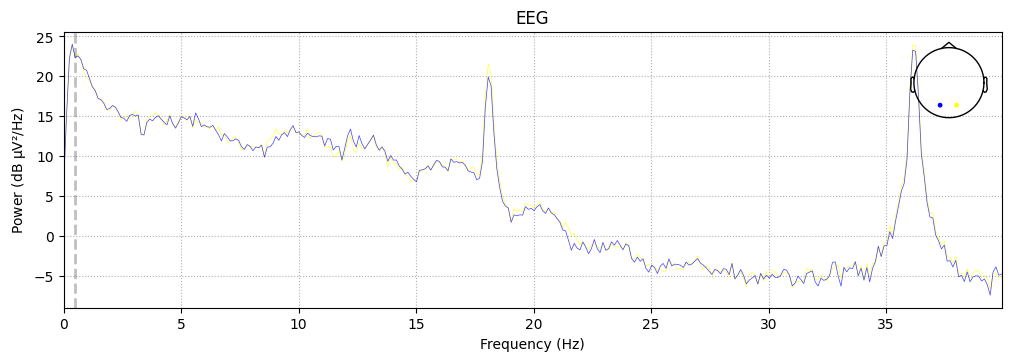

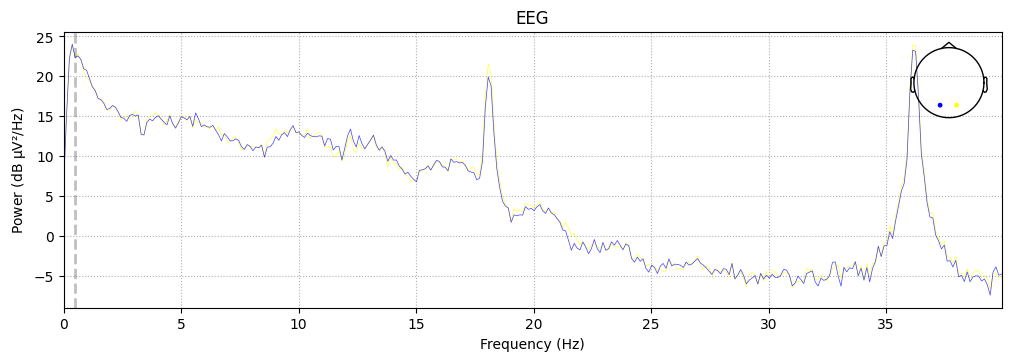

In [29]:
rest_eeg_data.compute_psd(tmax=np.inf, fmax=40).plot(picks=['O1', 'O2'])

The PSD shows reduced alpha power, which is characteristic of eyes-open with fixation. The alpha rhythm is suppressed, a phenomenon known as alpha blocking due to activation of the visual cortex from visual input 

#### Artifact inspection

##### 1- ECG Artifact

##### Check Data

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 285 (average pulse 70.6611570247934 / min.)
Not setting metadata
285 matching events found
No baseline correction applied
Using data from preloaded Raw for 285 events and 251 original time points ...
1 bad epochs dropped
Not setting metadata
284 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


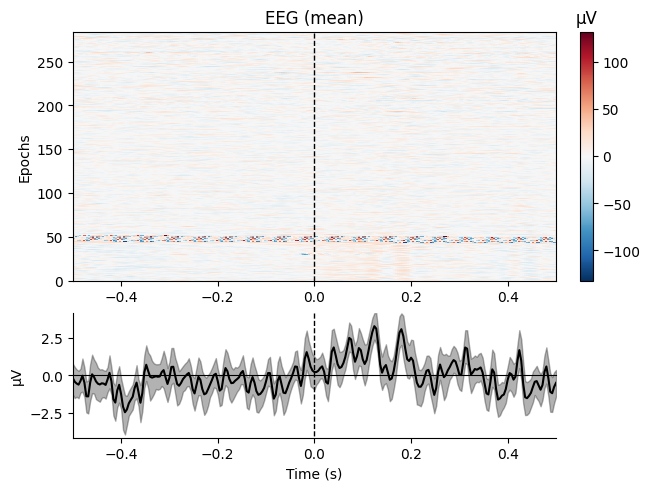

[<Figure size 640x480 with 3 Axes>]

In [30]:
# Create epochs centered around the detected heartbeat artifacts
ecg_epochs = mne.preprocessing.create_ecg_epochs(check_eeg_data)

# Show an image plot of the detected ECG artifacts along with the average ERF across artifacts
ecg_epochs.plot_image(combine="mean")

##### Rest Data

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 606 (average pulse 58.36276083467095 / min.)
Not setting metadata
606 matching events found
No baseline correction applied
Using data from preloaded Raw for 606 events and 251 original time points ...
1 bad epochs dropped
Not setting metadata
605 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


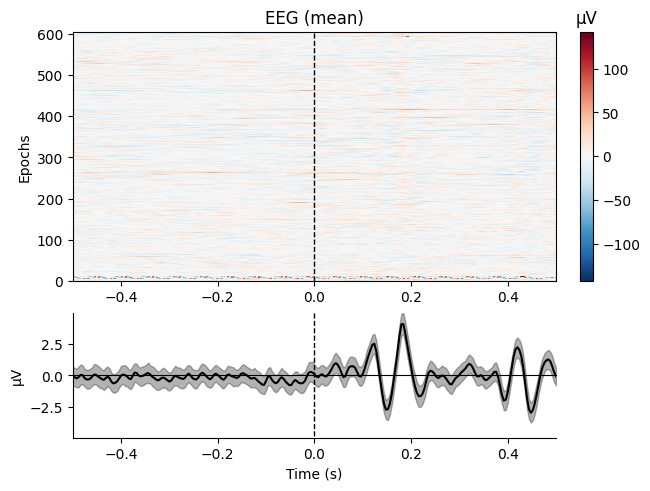

[<Figure size 640x480 with 3 Axes>]

In [31]:
# Create epochs centered around the detected heartbeat artifacts
ecg_epochs = mne.preprocessing.create_ecg_epochs(rest_eeg_data)

# Show an image plot of the detected ECG artifacts along with the average ERF across artifacts
ecg_epochs.plot_image(combine="mean")

 - Both the check and rest EEG data show minimal residual ECG (BCG) artifacts after preprocessing, with peak amplitudes of ~2.5 µV in the averaged evoked response.

 - The time-frequency plots indicate high consistency across epochs, with no significant outliers, confirming effective BCG correction as per the article’s pipeline.



##### 2- Occular Artifact

##### Check data

Using EOG channels: EOGL, EOGU
EOG channel index for this subject is: [62 63]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOGU for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 103 significant peaks
Number of EOG events detected: 103
Not setting metadata
103 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 103 events and 251 original time points ...
0 bad epochs dropped
Not se

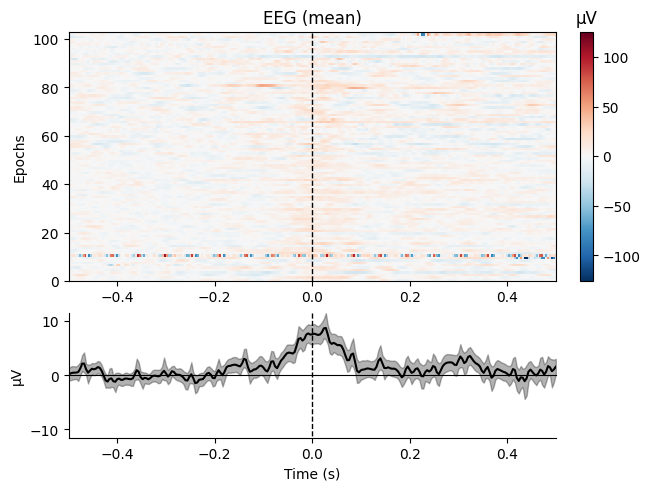

No projector specified for this dataset. Please consider the method self.add_proj.


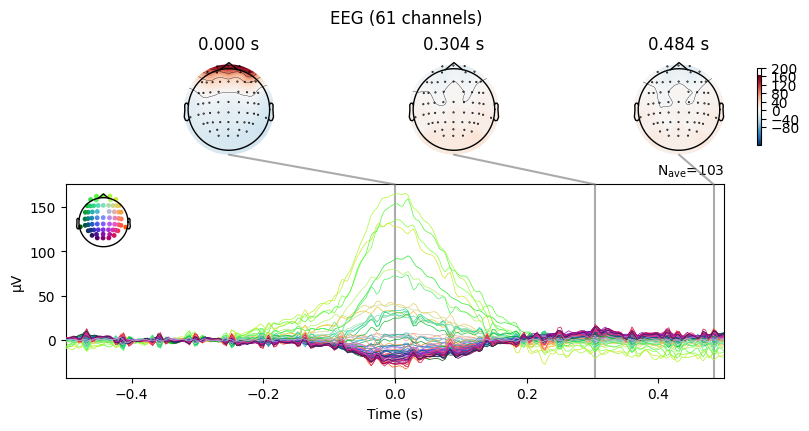

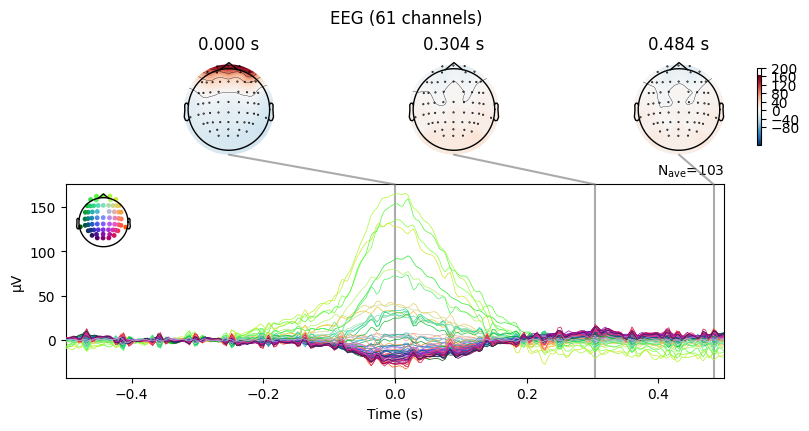

In [33]:
# Create epochs centered around the detected occular artifacts
eog_epochs = mne.preprocessing.create_eog_epochs(check_eeg_data, baseline=(-0.5, -0.2))

# Show an image plot of the detected occular artifacts along with the average ERF across artifacts
eog_epochs.plot_image(combine="mean")
eog_epochs.average().plot_joint()

The check EEG data shows a prominent ocular artifact (likely an eye blink) around 100 ms after the event, as evidenced by the positive peak in the mean ERP, the divergence in the butterfly plot, and the frontal positivity in the topographic map at 0.304 s. The artifact is consistent across many of the 103 epochs, suggesting that the subject frequently blinked in response to the "SYNC ON" events.

##### Rest data

Using EOG channels: EOGL, EOGU
EOG channel index for this subject is: [62 63]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOGL for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 12 significant peaks
Number of EOG events detected: 12
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 12 events and 251 original time points ...
0 bad epochs dropped
Not settin

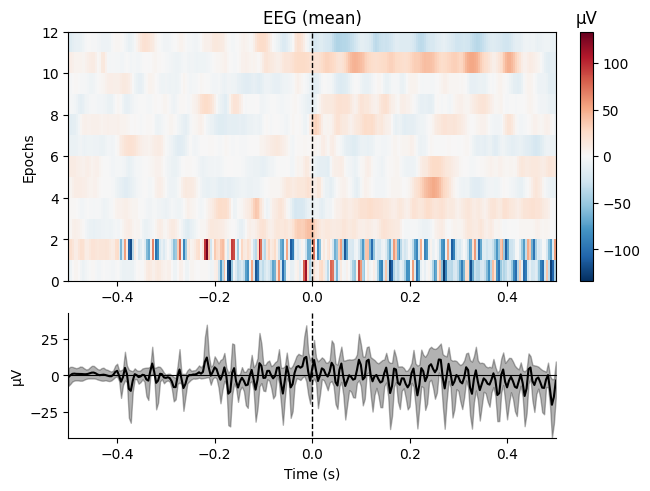

No projector specified for this dataset. Please consider the method self.add_proj.


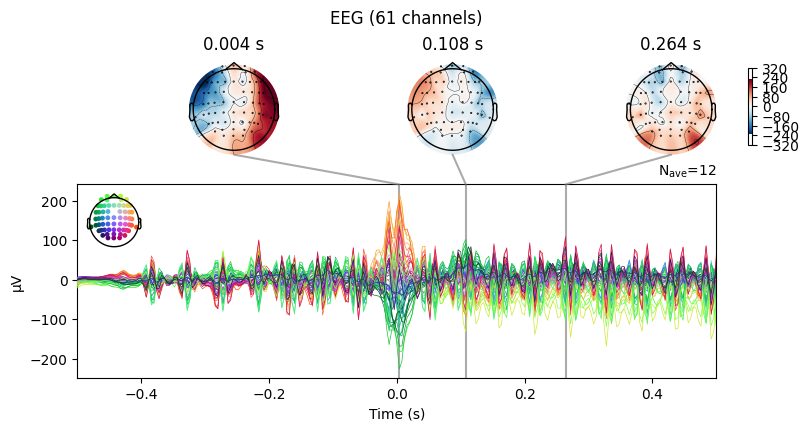

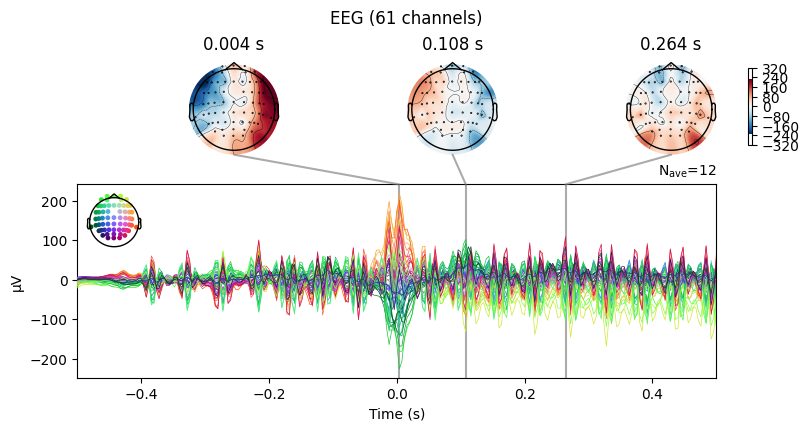

In [26]:
# Create epochs centered around the detected occular artifacts
eog_epochs = mne.preprocessing.create_eog_epochs(rest_eeg_data, baseline=(-0.5, -0.2))

# Show an image plot of the detected occular artifacts along with the average ERF across artifacts
eog_epochs.plot_image(combine="mean")
eog_epochs.average().plot_joint()

The rest EEG data also shows a prominent ocular artifact (likely an eye blink) around 100 ms after the event, as evidenced by the positive peak in the mean ERP, the divergence in the butterfly plot, and the frontal positivity in the topographic map at 0.108 s. The artifact is less consistent across epochs due to the smaller number of trials (12 vs. 103), but the amplitude is larger (200 μV vs. 150 μV), suggesting a stronger blink response in the trials that do show the artifact

**Recommendations for Artifact Removal:**

 - Both datasets would benefit from ocular artifact removal to isolate true brain activity:
   
  - Independent Component Analysis (ICA): Use ICA to identify and remove components associated with eye blinks (typically showing frontal positivity and a characteristic time course).

    
  - Regression-Based Methods: Regress out the eye blink artifact using EOG (electrooculogram) channels if available.

    
 - After artifact removal, re-compute the ERPs to see if there are underlying brain responses (e.g., P1, N1 components) that are currently masked by the eye blinks.
